In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [12]:
# import all important libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [24]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [25]:
train_df.shape,test_df.shape

((7613, 5), (3263, 4))

In [26]:
train_df.isnull().sum()/100

id           0.00
keyword      0.61
location    25.33
text         0.00
target       0.00
dtype: float64

In [27]:
test_df.isnull().sum()/100

id           0.00
keyword      0.26
location    11.05
text         0.00
dtype: float64

In [28]:
missing_values_cols = train_df.isnull().sum()

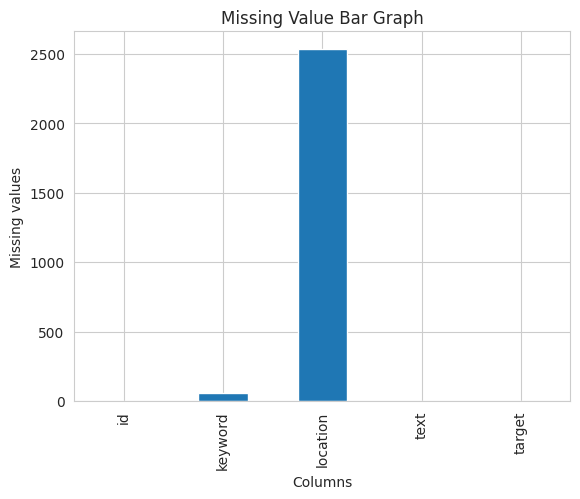

In [29]:
sns.set_style(style='whitegrid')
plt.title("Missing Value Bar Graph")
missing_values_cols.plot(kind='bar')
plt.xlabel("Columns")
plt.ylabel("Missing values")
plt.show()

In [50]:
train_df['target'].value_counts()

target
0    4323
1    3229
Name: count, dtype: int64

# Feature Engineering

In [30]:
# delete useless columns

train_df.drop(
    columns=["id","location"],
    axis=1,
    inplace=True
)

In [31]:
train_df.head()

,keyword,text,target
0,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [32]:
train_df = train_df.dropna()
train_df.head()

,keyword,text,target
31,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,ablaze,We always try to bring the heavy. #metal #RT h...,0
33,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,ablaze,Crying out for more! Set me ablaze,0
35,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


# Data Preprocessing

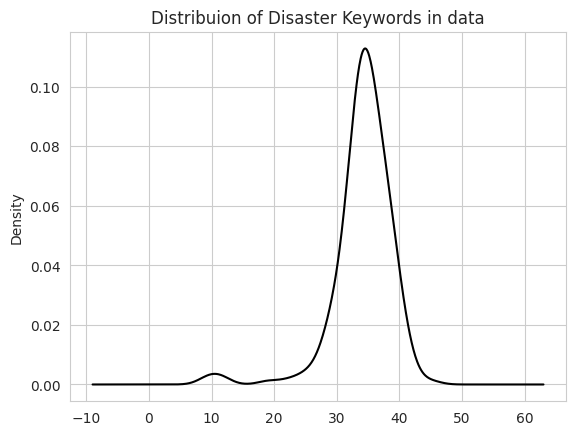

In [43]:
plt.title("Distribuion of Disaster Keywords in data")
train_df['keyword'].value_counts().plot(
    kind='kde',
    color='black'
)
plt.show()

# Clean Text 

In [44]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def clean_text(text):
    # Remove HTML tags and special characters
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters except spaces

    # Convert uppercase to lowercase
    text = text.lower()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    cleaned_words = [word for word in words if word not in stop_words]
    cleaned_text = ' '.join(cleaned_words)

    return cleaned_text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
train_df['clean_text'] = train_df['text'].apply(clean_text)

In [49]:
train_df.head()

,keyword,text,target,clean_text
31,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,bbcmtd wholesale markets ablaze httptcolhyxeohy6c
32,ablaze,We always try to bring the heavy. #metal #RT h...,0,always try bring heavy metal rt httptcoyao1e0xngw
33,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africanbaze breaking newsnigeria flag set abla...
34,ablaze,Crying out for more! Set me ablaze,0,crying set ablaze
35,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,plus side look sky last night ablaze httptcoqq...


# Data Preprocessing

In [51]:
from sklearn.preprocessing import LabelEncoder

In [52]:
le = LabelEncoder()
train_df['keyword_num'] = le.fit_transform(train_df['keyword'])

In [53]:
train_df.head()

,keyword,text,target,clean_text,keyword_num
31,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,bbcmtd wholesale markets ablaze httptcolhyxeohy6c,0
32,ablaze,We always try to bring the heavy. #metal #RT h...,0,always try bring heavy metal rt httptcoyao1e0xngw,0
33,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africanbaze breaking newsnigeria flag set abla...,0
34,ablaze,Crying out for more! Set me ablaze,0,crying set ablaze,0
35,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,plus side look sky last night ablaze httptcoqq...,0


# Text Vectorization

In [57]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [58]:
texts = train_df['clean_text'].tolist()

In [61]:
texts[0:10]

['bbcmtd wholesale markets ablaze httptcolhyxeohy6c',
 'always try bring heavy metal rt httptcoyao1e0xngw',
 'africanbaze breaking newsnigeria flag set ablaze aba httptco2nndbgwyei',
 'crying set ablaze',
 'plus side look sky last night ablaze httptcoqqsmshaj3n',
 'phdsquares mufc theyve built much hype around new acquisitions doubt set epl ablaze season',
 'inec office abia set ablaze httptco3imaomknna',
 'barbados bridgetown jamaica two cars set ablaze santa cruz head st elizabeth police superintende httptcowdueaj8q4j',
 'ablaze lord',
 'check httptcoroi2nsmejj httptco3tj8zjin21 httptcoyduixefipe httptcolxtjc87kls nsfw']

In [78]:
vac_size = 20000
max_len = 10

tokenizer = Tokenizer(
    num_words=vac_size,
    oov_token='<OOV>'
)

In [79]:
tokenizer.fit_on_texts(
    texts=texts
)

In [80]:
len(tokenizer.word_counts), len(tokenizer.word_index)

(22182, 22183)

## Change into Sequences

In [81]:
seq = tokenizer.texts_to_sequences(
    texts
)

In [82]:
seq[0:5]

[[6606, 2688, 1757, 501, 6607],
 [172, 746, 842, 747, 1058, 36, 6608],
 [6609, 339, 6610, 679, 160, 501, 1002, 6611],
 [1452, 160, 501],
 [1573, 621, 76, 946, 67, 152, 501, 6612]]

In [83]:
pad_seq = pad_sequences(
    sequences=seq,
    maxlen=max_len,
    padding='post',
    dtype='int16'
)
pad_seq[0:5]

array([[6606, 2688, 1757,  501, 6607,    0,    0,    0,    0,    0],
       [ 172,  746,  842,  747, 1058,   36, 6608,    0,    0,    0],
       [6609,  339, 6610,  679,  160,  501, 1002, 6611,    0,    0],
       [1452,  160,  501,    0,    0,    0,    0,    0,    0,    0],
       [1573,  621,   76,  946,   67,  152,  501, 6612,    0,    0]],
      dtype=int16)

In [84]:
pad_seq.shape

(7552, 10)

In [88]:
key_seq = tokenizer.texts_to_sequences(train_df['keyword'])

# Apply ML Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import BatchNormalization,Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.utils import to_categorical
import warnings as wn
wn.filterwarnings('ignore')

In [106]:
x = pad_seq
y = train_df['target']

In [107]:
y.shape

(7552,)

In [109]:
y = to_categorical(
    y,
    num_classes=2
)

In [111]:
y

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [112]:
x.shape,y.shape

((7552, 10), (7552, 2))

In [113]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=0,
    shuffle=True
)

In [114]:
x_train.shape,x_test.shape

((6041, 10), (1511, 10))

## LSTM Architecture

In [116]:
emb_dim = 16

model = Sequential()
model.add(Embedding(input_dim=vac_size, output_dim=emb_dim, input_length=max_len))
model.add(LSTM(units=20, activation='relu', return_sequences=True))
model.add(LSTM(units=20, activation='relu', return_sequences=False))
model.add(BatchNormalization())
model.add(Dense(units=2, activation='softmax'))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [117]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size=32,
    epochs=10,
    validation_data=(x_test,y_test),
    callbacks=early_stopping
)

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6608 - loss: 0.6162 - val_accuracy: 0.7565 - val_loss: 0.6080
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8871 - loss: 0.3033 - val_accuracy: 0.7565 - val_loss: 0.5231
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9464 - loss: 0.1606 - val_accuracy: 0.7399 - val_loss: 0.6201
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9652 - loss: 0.1032 - val_accuracy: 0.7478 - val_loss: 0.7417
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9744 - loss: 0.0731 - val_accuracy: 0.7392 - val_loss: 0.8210


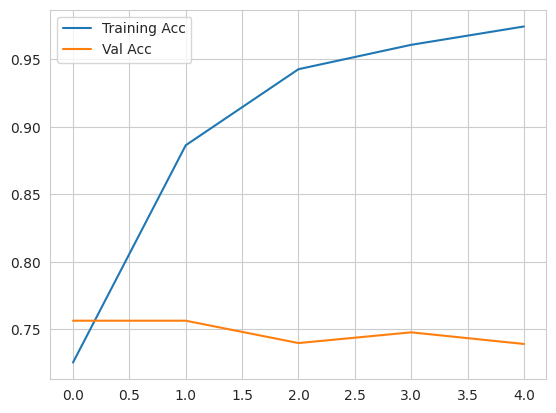

In [118]:
sns.lineplot(history.history['accuracy'],label='Training Acc')
sns.lineplot(history.history['val_accuracy'],label='Val Acc')
plt.show()